# 02 - Data from the Web 
Kiran Bacsa, Samuel Beuret, and Valentine Santarelli

## Important Notes
* Make sure you push on GitHub your Notebook with all the cells already evaluated (i.e., you don't want your colleagues to generate unnecessary Web traffic during the peer review)
* Don't forget to add a textual description of your thought process, the assumptions you made, and the solution you plan to implement!
* Please write all your comments in English, and use meaningful variable names in your code.
* You are not allowed to download manually the entire ranking -- rather you have to understand how the server loads it in your browser. 


Hints:
- Keep your Notebook clean and don't print the verbose output of the requests if this does not add useful information for the reader.
- In case of tie, use the order defined in the webpage.

In [3]:
# Import libraries
import requests
from bs4 import BeautifulSoup
import pandas as pd 
import numpy as np
import json 

import seaborn as sns

# set the default color palette
# try other options: 'Blues', sns.cubehelix_palette(8)
sns.set_palette('Blues')

# Seaborn can also use a context for different purpose
# possible values are paper, notebook, talk, and poster
sns.set_context("notebook")


import matplotlib.pyplot as plt
%matplotlib inline

import pickle
import re

import warnings
warnings.filterwarnings('ignore')
from difflib import SequenceMatcher

##  200 top-ranking universities in www.topuniversities.com ([ranking 2018](https://www.topuniversities.com/university-rankings/world-university-rankings/2018)). 

### Scrapping the web page 
Using Postman, part of the information needed was found  in a JSON file (name, rank, country, and region). The remaining information to scrap ranking was found using Beautiful Soup on each university page.By inspecting the web page, we found that the information to scrap was in the *div* of *class = faculty-main*. 
* number of faculty members international corresponds to the *div* of *class=inter faculty*
* number of faculty members total corresponds to the *div* of *class=total faculty*
* number of students international corresponds to the *div* of *class=total inter*
* number of students total corresponds to the *div* of *class=total student*

In [ ]:

# get name, rank, country and region of the 200 first universities

#url found using Postman
url='https://www.topuniversities.com/sites/default/files/qs-rankings-data/357051.txt?_=1508005996450'
universities= requests.get(url).json()['data'][0:200] #take the first 200 universities
#first part of the dataframe for topuniversities.com
df_top1 = pd.DataFrame(universities)
df_top1 = df_top1.drop(['cc','core_id','guide', 'logo','score','stars','nid'], axis=1) #don't need this information

#list of urls to universities pages
urls =list(df_top1['url'])

# function to get the rest of the needed information on each university page in a dictionnary
def get_details(url):
    university= requests.get('https://www.topuniversities.com' + url)
    soup= BeautifulSoup(university.text,'html.parser')
    data= soup.find_all('div', class_= 'faculty-main') 

    # number of faculty members international
    if(soup.find_all('div', class_ = 'inter faculty') != []):
        inter_fac_mem = float(soup.find_all('div', class_ = 'inter faculty')[0].find_all('div', class_ = 'number')[0].string.replace(',',''))
    else:
        inter_fac_mem = float('nan')
        
    # number of faculty members total
    if(soup.find_all('div', class_ = 'total faculty')!= []):
        total_fac_mem = float(soup.find_all('div', class_ = 'total faculty')[0].find_all('div', class_ = 'number')[0].string.replace(',',''))
    else:
        total_fac_mem = float('nan')
        
    # number of students international
    if(soup.find_all('div', class_ = 'total inter')!= []):
        inter_student = float(soup.find_all('div', class_ = 'total inter')[0].find_all('div', class_ = 'number')[0].string.replace(',',''))
    else:
        inter_student = float('nan')
        
    # number of students total
    if(soup.find_all('div', class_ = 'total student')!= []):
        total_student = float(soup.find_all('div', class_ = 'total student')[0].find_all('div', class_ = 'number')[0].string.replace(',',''))
    else:
        total_student = float('nan')

    #output dictionnary (keep the url to merge later)
    details = {'url' : url, '(QS) #faculty members international' : inter_fac_mem,
          '(QS) #faculty members total' : total_fac_mem,
          '(QS) #students international': inter_student,
          '(QS) #students total' : total_student}
    return details

#list of dictionnaries 
details = []    
for url in urls:
    details.append(get_details(url))
#convert to pd.DataFrame
df_top2 = pd.DataFrame(details)

#merge the two dataframes using the url
df_top= pd.merge(df_top1, df_top2, 'outer')
df_top.rename(columns={'rank_display': '(QS) rank', 'title': 'name'}, inplace=True)
df_top = df_top.drop('url', axis=1) #drop the url once the merge is done

df_top.head()


In order to avoid scrapping the page every time we need the dataset *df_top*, the later was exported in a file using the pandas fucntion *to_pickle()*, and imported with *from_pickle()*.

In [ ]:
#USE PICKLE TO SAVE DF
filename="./data/QS_ranking"
df_top.to_pickle(filename)

In [2]:
#USE PICKLE TO LOAD DF
filename="./data/QS_ranking"
df_top =pd.read_pickle(filename)
df_top.head()

,country,(QS) rank,region,name,(QS) #faculty members international,(QS) #faculty members total,(QS) #students international,(QS) #students total
0,United States,1,North America,Massachusetts Institute of Technology (MIT),1679.0,2982.0,3717.0,11067.0
1,United States,2,North America,Stanford University,2042.0,4285.0,3611.0,15878.0
2,United States,3,North America,Harvard University,1311.0,4350.0,5266.0,22429.0
3,United States,4,North America,California Institute of Technology (Caltech),350.0,953.0,647.0,2255.0
4,United Kingdom,5,Europe,University of Cambridge,2278.0,5490.0,6699.0,18770.0


We verify that there is no tie in the ranking and if so we keep the order of display on the web page.
We found the ties using the *duplicated()* pandas function. Each time a duplicate is found (i.e a tie) we increment all the ranks below by one.
As expected the rank column is unique at the end.

In [3]:
df_top['(QS) rank']=df_top['(QS) rank'].str.extract('(\d+)').astype('int64')
bool_dup = df_top['(QS) rank'].duplicated()
ind_dup = bool_dup[bool_dup == True].index

#until no more duplicates
for ind in ind_dup :
    #add +1 the all the ranks below this duplicate
    df_top['(QS) rank'][ind : len(df_top['(QS) rank'])] = df_top['(QS) rank'][ind : len(df_top['(QS) rank']) ] + 1;
    
print(df_top['(QS) rank'].is_unique)



True


### Which are the best universities in term of: (a) ratio between faculty members and students, (b) ratio of international students?

In [ ]:
# adding the ratios to the df_top dataframe
df_top['(QS) faculty members/students'] = df_top['(QS) #faculty members total']/df_top['(QS) #students total']
df_top['(QS) international students/ total students'] = df_top['(QS) #students international']/df_top['(QS) #students total']
df_top.head()

In [ ]:
#Plotting the ratio faculty members/students for the 10 first universities
df_ratio1 = df_top.sort_values('(QS) faculty members/students', ascending =False) #sort by ratio
df_ratio1.set_index(['name'],inplace=True) #set name of universities as index for the plot
df_ratio1= df_ratio1['(QS) faculty members/students'] #extract only the column  needed

ax = df_ratio1[0:10].plot.bar()
ax.set_xlabel("Universities", fontsize=12)
plt.title("Ratio between faculty members and students")
plt.show()


The best universities in term of ratio of faculty members and students are :
* Caltech
* Yale University
* University of Oxford

In [ ]:
#Plotting the ratio of international students for the first 10 universities
df_ratio2 = df_top.sort_values('(QS) international students/ total students', ascending =False)#sort by ratio
df_ratio2.set_index(['name'],inplace=True) #set name of universities as index for the plot
df_ratio2= df_ratio2['(QS) international students/ total students']#extract only the column  needed

ax = df_ratio2[0:10].plot.bar()
ax.set_xlabel("Universities", fontsize=12)
plt.title("Ratio of international students")
plt.show()

The best universities in term of ratio of international students are :
* LSE
* EPFL
* Imperial College London



### Which are the best country in term of: (a) ratio between faculty members and students, (b) ratio of international students?

In [ ]:
#Create a new dataframe by aggregating values by country.
df_country = df_top.groupby('country').mean()
df_country.head()

In [ ]:
#sort by ratio and extract the columns needed
df_country_ratio1 = df_country.sort_values('(QS) faculty members/students', ascending =False)
df_country_ratio1= df_country_ratio1['(QS) faculty members/students']

#Plot the sorted countries
ax = df_country_ratio1[0:10].plot.bar()
ax.set_xlabel("Country", fontsize=12)
plt.title("Ratio between faculty members and students")
plt.show()

The best countries in term of ratio of faculty members and students are :
* Russia
* Denmark
* Saudi Arabia

In [ ]:
#sort by ratio and extract the columns needed
df_country_ratio2 = df_country.sort_values('(QS) international students/ total students', ascending =False)
df_country_ratio2= df_country_ratio2['(QS) international students/ total students']

#Plot the sorted countries
ax = df_country_ratio2[0:10].plot.bar()
ax.set_xlabel("Country", fontsize=12)
plt.title("Ratio of international students")
plt.show()

The best countries in term of ratio of international students are :
* UK
* Australia
* Switzerland

### Which are the best region in term of: (a) ratio between faculty members and students, (b) ratio of international students?

In [ ]:
#Create a new dataframe by aggregating values by region.
df_region = df_top.groupby('region').mean()
df_region.head()

In [ ]:
#Sort by ratio and extract the columns needed
df_region_ratio1 = df_region.sort_values('(QS) faculty members/students', ascending =False)
df_region_ratio1= df_region_ratio1['(QS) faculty members/students']

#Plot the sorted regions
ax = df_region_ratio1.plot.bar()
ax.set_xlabel("Region", fontsize=12)
plt.title("Ratio between faculty members and students")
plt.show()

The best regions in term of ratio of faculty members and students are :
* North America
* Asia
* Europe

In [ ]:
df_region_ratio2 = df_region.sort_values('(QS) international students/ total students', ascending =False)
df_region_ratio2= df_region_ratio2['(QS) international students/ total students']

ax = df_region_ratio2.plot.bar()
ax.set_xlabel("Region", fontsize=12)
plt.title("Ratio of international students")
plt.show()

The best regions in term of ratio of international students are :
* Oceania
* Europe
* North America

##  200 top-ranking universities in www.timeshighereducation.com ([ranking 2018](http://timeshighereducation.com/world-university-rankings/2018/world-ranking)).

### Scrapping the web page 

On the page of the 2018 Times Higher Eduction ranking, we have found a direct link to a JSON page (given by the URL in the code below). This allowed us to directly load the JSON dataset with the tools provided by pandas, without using Requests or BeautifulSoup.

We performed a preprocessing by selecting only the first 200 ranks of the dataset, removing the "equal" symbols in front of the rank numbers, renaming the columns and removing the commas in the numbers.

Since international student and staff ratios are given, we need to multiply them with the overall number of students to get the total staff and international students count. The number of international staff is however not available in the dataset, nor the region of the university. 

We also added a command to save the dataset in a file to avoid loading the data from internet at every execution.

In [ ]:

url='https://www.timeshighereducation.com/sites/default/files/the_data_rankings/world_university_rankings_2018_limit0_369a9045a203e176392b9fb8f8c1cb2a.json'

json_dict= requests.get(url).json()
raw_data = pd.DataFrame(json_dict['data'])
raw_data.columns
df_time=raw_data[['name','rank','location','stats_number_students','stats_pc_intl_students','stats_student_staff_ratio']]

df_time['rank']=df_time['rank'].str.extract('(\d+)').astype('int64')
df_time = df_time.loc[df_time['rank']<201]
df_time.rename(columns={'location':'country','stats_number_students':'students','stats_pc_intl_students':'international students','stats_student_staff_ratio':'staff'},inplace=True)

df_time['students'] = df_time['students'].str.replace(',','').astype('int64')

df_time['international students'] = df_time['international students'].str.extract('(\d+)').astype('float64')
df_time['international students'] = (df_time['international students']/100)*df_time['students'].astype('float64')
df_time['international students'] = df_time['international students'].astype('int64')

df_time['staff'] = df_time['staff'].astype('float64')
df_time['staff'] = df_time['students'].astype('float64')/df_time['staff']
df_time['staff'] = df_time['staff'].astype('int64')

df_time.rename(columns={'rank': '(Times) rank', 'title': 'name','staff':'(Times) #faculty members total', 'students':'(Times) #students total','international students':'(Times) #students international' }, inplace=True)
df_time.head()

In [ ]:
#USE PICKLE TO SAVE DF
filename="./data/Times_ranking"
df_time.to_pickle(filename)

In [63]:
#USE PICKLE TO LOAD DF
filename="./data/Times_ranking"
df_time =pd.read_pickle(filename)
df_time.head()

,name,(Times) rank,country,(Times) #students total,(Times) #students international,(Times) #faculty members total
0,University of Oxford,1,United Kingdom,20409,7755,1822
1,University of Cambridge,2,United Kingdom,18389,6436,1687
2,California Institute of Technology,3,United States,2209,596,339
3,Stanford University,3,United States,15845,3485,2112
4,Massachusetts Institute of Technology,5,United States,11177,3800,1284


Similarly to the QS dataset, we removed the duplicated rank in the list, and verified that they are unique.

In [65]:
bool_dup = df_time['(Times) rank'].duplicated()
ind_dup = bool_dup[bool_dup == True].index

#until no more duplicates
for ind in ind_dup :
    #add +1 the all the ranks below this duplicate
    df_time['(Times) rank'][ind : len(df_time['(Times) rank'])] = df_time['(Times) rank'][ind : len(df_time['(Times) rank']) ] + 1;
    
print(df_time['(Times) rank'].is_unique)

True


### Which are the best universities in term of: (a) ratio between faculty members and students, (b) ratio of international students?

We displayed the ratios between the faculty members and students for the 10 first universities.

In [66]:
df_time['(Times) faculty members/students']=df_time['(Times) #faculty members total'].astype('float64')/df_time['(Times) #students total']
df_time['(Times) international students/ total students']=df_time['(Times) #students international'].astype('float64')/df_time['(Times) #students total']

df_plot=df_time[['name','(Times) faculty members/students','(Times) international students/ total students']]
df_plot.set_index(['name'],inplace=True) #set name of universities as index for the plot

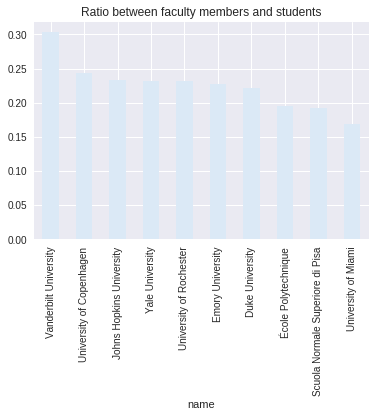

In [67]:
df_plot.sort_values('(Times) faculty members/students',ascending=False)['(Times) faculty members/students'].head(10).plot(kind='bar', title='Ratio between faculty members and students')

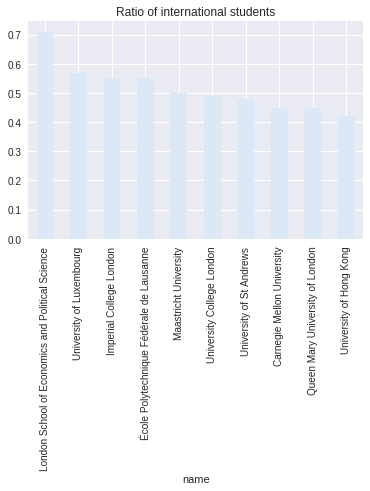

In [68]:
df_plot.sort_values('(Times) international students/ total students',ascending=False)['(Times) international students/ total students'].head(10).plot(kind='bar', title='Ratio of international students')

According to the Times ranking, we can see that the three best universities concerning the staff ratio :
* Vanderbuilt University
* University of Copenhagen
* Johns Hopkins University

Similarly, the best universities concerning the international students ratio are
* London School of Economics and Polotical Science
* University of Luxembourg
* Imperial College London

We can see that it is different from the universities obtained with the QS ranking.

### Which are the best country in term of: (a) ratio between faculty members and students, (b) ratio of international students?

We averaged the staff and international students ratios for every country present in the Times ranking and display them in a plot.

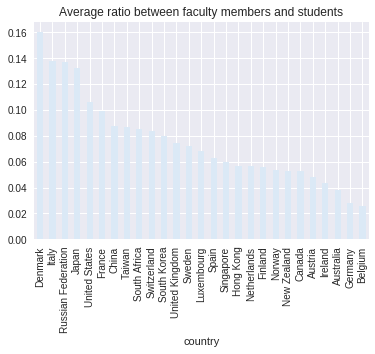

In [69]:
df_time.groupby(['country'])['(Times) faculty members/students'].mean().sort_values(ascending=False).plot(kind='bar',title='Average ratio between faculty members and students')

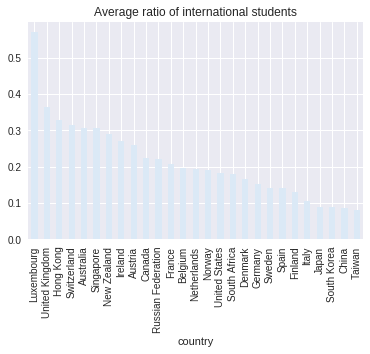

In [70]:
df_time.groupby(['country'])['(Times) international students/ total students'].mean().sort_values(ascending=False).plot(kind='bar',title='Average ratio of international students')

The three coutries were the staff ratio is the highest are:
* Denmark
* Italy
* Russian Federation

The countries were the international students ratio is the highest are:
* Luxemburg
* United Kingdom
* Hong Kong

In the same way than with the universities, the results are not completely coherents with the QS ranking, even if more or less the same countries are on the top of both lists.

### Which are the best region in term of: (a) ratio between faculty members and students, (b) ratio of international students?

Since the region of each university are not given in the original dataset, we needed to manually define them by sorting the different countries. We averaged the ratios and displayed them, and we also displayed the total number of universities per region, to have a comparisson basis.

In [77]:
region = {'Asia':['China','Hong Kong','Japan','Singapore','South Korea','Taiwan']
          ,'Europe':['Austria','Belgium','Denmark','Finland','France','Germany','Ireland','Italy','Luxembourg','Netherlands','Norway','Russian Federation','Spain','Sweden','Switzerland','United Kingdom']
          ,'North America':['Canada','United States']
          ,'Africa':['South Africa']
          ,'Oceania':['Australia','New Zealand']}

region = { f : i for i in region for f in region[i] }

df_time['region'] = df_time['country'].map(region)

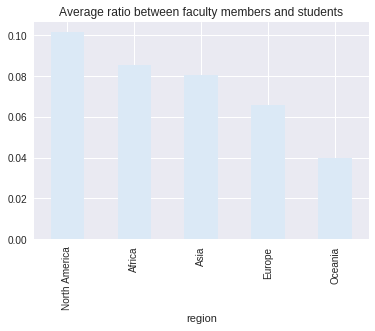

In [78]:
df_time.groupby(['region'])['(Times) faculty members/students'].mean().sort_values(ascending=False).plot(kind='bar',title='Average ratio between faculty members and students')

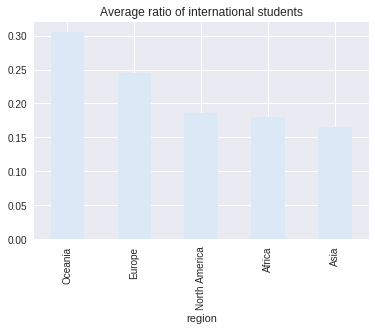

In [76]:
df_time.groupby(['region'])['(Times) international students/ total students'].mean().sort_values(ascending=False).plot(kind='bar',title='Average ratio of international students')

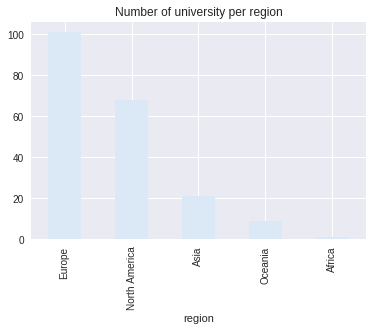

In [80]:
df_time.groupby(['region'])['(Times) rank'].count().sort_values(ascending=False).plot(kind='bar',title='Number of university per region')

The three regions where the staff ratios are the highest are:
* North America
* Africa
* Asia

The three regions where the international student ratios are the highest are:
* Oceania
* Europe
* North America

We can see that the results are coherent with the ones given by the QS ranking. One important difference is the Africa's average staff ratio, but it can be due to the uncertainty due to the only one relevant university in Africa.


## Merging of the two DataFrames using university names. 
Match universities' names as well as you can, and explain your strategy. Keep track of the original position in both rankings.

One of the main problems that was observed was the fact that the Times ranking uses the universties' names expressed in their native language unlike the Qs-Ranking which uses the English name. The first step was therefore to clean our data by translating certain key words and caracters to their English equivalents. A specific translation was made for LMU Munich because its name in the QS-ranking was too distinct from its Times counterpart to be matched. Furthermore, redundant stop words that do not carry any relevant information such as 'The' and 'Of' were removed in order to make the university names more distinct.

In [12]:
replace_target = ["É","é","&","Ludwig-Maximilians-Universität","-","Universite","Universität","Universitaet","Universitat","Technische","Autònoma","München"]
replace_with = ["E","e","and","LMU"," ","University","University","University","University","Technical","Autonomous","Munich"]
remove = ["The ","the ","Of ","of "]

for i in range(len(replace_target)):
    df_top['name'] = df_top['name'].str.replace(replace_target[i], replace_with[i])
    df_time['name'] = df_time['name'].str.replace(replace_target[i], replace_with[i])

for word in remove:
    df_top['name'] = df_top['name'].str.replace(word, "")
    df_time['name'] = df_time['name'].str.replace(word, "")


We can then define the functions that will be used to match the university names between each other. The first step in each function groups the universities by country. This operation considerably reduces the number of possible false positives during the matching phase. During this matching phase, for each country, we compare the similarity of the universities between themselves. If this similarity is above a predefined threshold, both universities are considered to be a match and their indexes are paired together. These universities are then removed from the symmetric difference datasets. The first function uses the SequenceMatcher similarity. This similarity is defined as 2.0\*M/T, where T is the total number of elements in both sequences, and M is the number of matches. The second function defines the similarity as the sum of the ratios of the number of common words versus the length of the universities' names (this function was mainly defined in order to compare similar names with different word orders). Both these functions return the dataframes containing the universities that haven't been paired up as well as the list of the paired up indexes.

In [13]:
# match universities according to name similarity
def find_common_unmerged(df_top_out, df_time_out, threshold):
    n_duplicates = 0
    matched_top = []
    matched_time = []
    
    top_grouped = df_top_out.groupby('country')
    time_grouped = df_time_out.groupby('country')

    countries = pd.Series(list(set(df_top_out['country']).intersection(set(df_time_out['country']))))
    
    for country in countries:        
        unis_top = top_grouped.get_group(name=country)
        unis_time = time_grouped.get_group(name=country)     
        for name in unis_top['name']:
            for compare in unis_time['name']:
                score = SequenceMatcher(None, name, compare).ratio()
                if score > threshold:
                    n_duplicates = n_duplicates + 1
                    print('Matched ', name, ' with ', compare, ' with score ',score)
                    matched_top.extend(df_top_out.index[df_top_out['name'] == name])
                    matched_time.extend(df_time_out.index[df_time_out['name'] == compare])
                    
    print('Number of duplicates found : ', n_duplicates, 'out of ', len(df_top_out['name']), ' unmerged universities.')
    df_top_out = df_top_out.drop(matched_top, axis=0)
    df_time_out = df_time_out.drop(matched_time, axis=0)
    return df_top_out, df_time_out, matched_top, matched_time

In [14]:
# match universities according to common substring
def find_common_unmerged_by_substrings(df_top_out, df_time_out, threshold):
    n_duplicates = 0
    matched_top = []
    matched_time = []
    
    top_grouped = df_top_out.groupby('country')
    time_grouped = df_time_out.groupby('country')

    countries = pd.Series(list(set(df_top_out['country']).intersection(set(df_time_out['country']))))
    
    for country in countries:        
        unis_top = top_grouped.get_group(name=country)
        unis_time = time_grouped.get_group(name=country)     
        for name in unis_top['name']:
            for compare in unis_time['name']:
                top_name_words = name.split()
                time_name_words = compare.split()
                common = set(top_name_words).intersection( set(time_name_words) )
                score = len(common)/len(top_name_words) + len(common)/len(time_name_words)
                if score > threshold:
                    n_duplicates = n_duplicates + 1
                    print('Matched ', name, ' with ', compare, ' with score ',score)
                    matched_top.extend(df_top_out.index[df_top_out['name'] == name])
                    matched_time.extend(df_time_out.index[df_time_out['name'] == compare])
                    
    print('Number of duplicates found : ', n_duplicates, 'out of ', len(df_top_out['name']), ' unmerged universities.')
    df_top_out = df_top_out.drop(matched_top, axis=0)
    df_time_out = df_time_out.drop(matched_time, axis=0)
    return df_top_out, df_time_out, matched_top, matched_time


We can now run these functions with different thresholds on the subdataframes that contain the symmetric differences of both datasets with respect to names.

In [15]:
# get universities that weren't merged
df_top_out = df_top[~df_top['name'].isin(df_time['name'])]
df_time_out = df_time[~df_time['name'].isin(df_top['name'])]

total_matched_top = []
total_matched_time = []
m_top = []
m_time = []

# threshold : 0.9
df_top_out, df_time_out, m_top, m_time = find_common_unmerged(df_top_out, df_time_out, 0.9)
total_matched_top.extend(m_top)
total_matched_time.extend(m_time)
del m_top[:]
del m_time[:]

# threshold : 0.85
df_top_out, df_time_out, m_top, m_time = find_common_unmerged(df_top_out, df_time_out, 0.85)
total_matched_top.extend(m_top)
total_matched_time.extend(m_time)
del m_top[:]
del m_time[:]

# by substrings
df_top_out, df_time_out, m_top, m_time = find_common_unmerged_by_substrings(df_top_out, df_time_out, 1.4)
total_matched_top.extend(m_top)
total_matched_time.extend(m_time)
del m_top[:]
del m_time[:]


Matched  ETH Zurich   Swiss Federal Institute Technology  with  ETH Zurich – Swiss Federal Institute Technology Zurich  with score  0.9108910891089109
Matched  Ecole Polytechnique Federale de Lausanne (EPFL)  with  Ecole Polytechnique Federale de Lausanne  with score  0.9195402298850575
Matched  KIT, Karlsruhe Institute Technology  with  Karlsruhe Institute Technology  with score  0.9230769230769231
Matched  Humboldt University zu Berlin  with  Humboldt University Berlin  with score  0.9454545454545454
Matched  Freie University Berlin  with  Free University Berlin  with score  0.9777777777777777
Matched  University de Montreal  with  University Montreal  with score  0.926829268292683
Matched  Massachusetts Institute Technology (MIT)  with  Massachusetts Institute Technology  with score  0.918918918918919
Matched  University California, Berkeley (UCB)  with  University California, Berkeley  with score  0.9117647058823529
Matched  University California, Los Angeles (UCLA)  with  Universi

Now that we have detected the university pairs, we can change the Times ranking names to their QS ranking equivalents and merge both datasets.

In [16]:
# replace time names with their top equivalent : 
for i in range(len(total_matched_time)):
    df_time.loc[total_matched_time[i],'name'] = df_top.loc[total_matched_top[i],'name']


In [17]:
df_merged = pd.merge(df_top, df_time, how='outer')
df_merged.head()

,country,(QS) rank,region,name,(QS) #faculty members international,(QS) #faculty members total,(QS) #students international,(QS) #students total,(Times) rank,(Times) #students total,(Times) #students international,(Times) #faculty members total,(Times) faculty members/students,(Times) international students/ total students
0,United States,1.0,North America,Massachusetts Institute Technology (MIT),1679.0,2982.0,3717.0,11067.0,5.0,11177.0,3800.0,1284.0,0.114879,0.339984
1,United States,2.0,North America,Stanford University,2042.0,4285.0,3611.0,15878.0,3.0,15845.0,3485.0,2112.0,0.133291,0.219943
2,United States,3.0,North America,Harvard University,1311.0,4350.0,5266.0,22429.0,6.0,20326.0,5284.0,2283.0,0.112319,0.259963
3,United States,4.0,North America,California Institute Technology (Caltech),350.0,953.0,647.0,2255.0,3.0,2209.0,596.0,339.0,0.153463,0.269805
4,United Kingdom,5.0,Europe,University Cambridge,2278.0,5490.0,6699.0,18770.0,2.0,18389.0,6436.0,1687.0,0.091740,0.349992


## Exploratory analysis
* Find useful insights in the data by performing an exploratory analysis. Can you find a strong correlation between any pair of variables in the dataset you just created? Example: when a university is strong in its international dimension, can you observe a consistency both for students and faculty members?

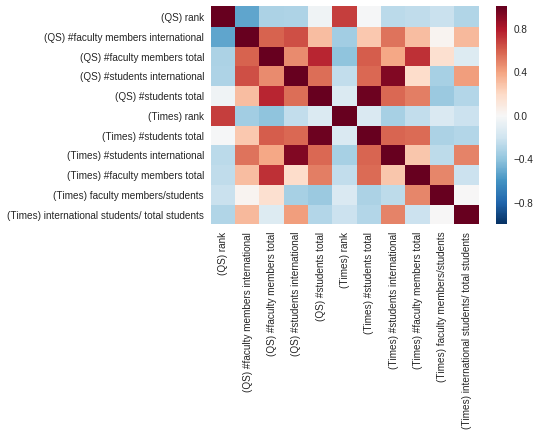

In [18]:
import seaborn as sns
#TO CHANGE LATER
# merge 'in' universities with same string name

df_merged = pd.merge(df_top, df_time, how='outer')
corr_pearson= df_merged.corr('pearson')

sns.heatmap(corr_pearson, 
            xticklabels=corr_pearson.columns.values,
            yticklabels=corr_pearson.columns.values)

 correlation  between
 
* faculty member international, faculty members total
* faculty member international, student international
* faculty member international, ratio fac/student
* faculty member international, international students (time)
* student international, ratio international students

In [ ]:
corr_spearman= df_merged.corr(method='spearman')

sns.heatmap(corr_spearman, 
            xticklabels=corr_spearman.columns.values,
            yticklabels=corr_spearman.columns.values)

In [ ]:
corr_kendall= df_merged.corr('kendall')

sns.heatmap(corr_kendall, 
            xticklabels=corr_kendall.columns.values,
            yticklabels=corr_kendall.columns.values)

In [ ]:
df_check= df_merged[[ '(QS) rank', '#faculty members total (QS)',
        '#students total (QS)',
       '#students international (QS)',
       'rank','staff', 'students',
       'international students']]
df_check = df_check.rename(columns={'QS rank': '(QS) rank','#faculty members total (QS)': '(QS) #faculty members total','#students total (QS)':'(QS) #students total', '#students international (QS)': '(QS) #students international' })
df_check = df_check.rename(columns={'rank': '(Times) rank ', 'staff': '(Times) #faculty members total','students':'(Times) #students total', 'international students':'(Times) #students international' });
corr_diff = df_check.corr();

test=corr_diff[['(QS) rank', '(QS) #faculty members total', '(QS) #students total',
       '(QS) #students international']].loc[
        '(Times) rank ':];
sns.heatmap(test)
            

# Defining the best university

* Can you find the best university taking in consideration both rankings? Explain your approach.

To determine the best university, we decided to use a Condorcet method (for futher informations: https://en.wikipedia.org/wiki/Condorcet_method) since it has interesting properties. Its basic principle is to elect a winner that beats every other concurrent (here, the universities) in a referundum at the majority of the voters (here, the rankings).

We group the univeristies two by two and we perform a vote (each university has a vote from one of the ranking if its score is higher than the other one). The overall score of the university is the number of vote it wins.

It has a drawback since many of the univerities are tied in ranking. So we tried to counter this effect by also considering the Shanghai ranking. Both results are shown below, firstly without the Shanghai ranking, and secondly with it.

In [ ]:
#Parsing the dataset of the Shanghai ranking

# get name, rank, country and region of the 200 first universities



# function to get the rest of the needed information on each university page in a dictionnary
'''
universities= requests.get('http://www.shanghairanking.com/ARWU2017.html')
soup= BeautifulSoup(universities.text,'html.parser')
html_shanghai= soup.find_all('table', id="UniversityRanking")
rank_shanghai_even= html_shanghai[0].find_all('tr', class_="bgfd")
rank_shanghai_odd= html_shanghai[0].find_all('tr', class_="bgf5")

uni_list=[]
for uni in rank_shanghai_even[0:50]:
    uni_rank=int(uni.find('td').text);
    uni_name=uni.find('a').text
    uni_url='http://www.shanghairanking.com/' + uni.find('a')['href']; 
    uni_request= requests.get(uni_url)
    uni_soup= BeautifulSoup(uni_request.text,'html.parser')
    uni_country= uni_soup.find('div', class_="tab_content").find_all('td')[5].text
    uni_region= uni_soup.find('div', class_="tab_content").find_all('td')[3].text
    uni_list.append({'name' : uni_name, 'rank Shanghai' : uni_rank,
          'country' : uni_country,
          'region': uni_region})

    
for uni in rank_shanghai_odd[0:50]:
    uni_rank=int(uni.find('td').text);
    uni_name=uni.find('a').text
    uni_url='http://www.shanghairanking.com/' + uni.find('a')['href']; 
    uni_request= requests.get(uni_url)
    uni_soup= BeautifulSoup(uni_request.text,'html.parser')
    uni_country= uni_soup.find('div', class_="tab_content").find_all('td')[5].text
    uni_region= uni_soup.find('div', class_="tab_content").find_all('td')[3].text
    uni_list.append({'name' : uni_name, 'rank Shanghai' : uni_rank,
          'country' : uni_country,
          'region': uni_region})

df_shanghai=pd.DataFrame(uni_list)

df_shanghai=df_shanghai.sort_values('rank Shanghai', ascending=True)
df_shanghai.head()

df_shanghai.index.is_unique
df_shanghai.set_index('rank Shanghai')

#USE PICKLE TO SAVE DF
filename="./data/Shanghai_ranking"
df_shanghai.to_pickle(filename)
'''

In [24]:
#loading the dataset

#USE PICKLE TO LOAD DF
filename="./data/Shanghai_ranking"
df_shanghai =pd.read_pickle(filename)
df_shanghai.head()

,country,name,rank Shanghai,region
0,USA,Harvard University,1,Northern America
50,USA,Stanford University,2,Northern America
1,UK,University of Cambridge,3,Northern Europe
51,USA,Massachusetts Institute of Technology (MIT),4,Northern America
2,USA,"University of California, Berkeley",5,Northern America


Here we merge the Shanghai dataset with the overall dataset obtained above. It is exactly the same principle with firstly removing and replacing some specific words, then finding common words and strings with also considering the country. There is however an additional step since we need to replace some country name with the one given in the merged dataset.

In [25]:



country_target=['USA','UK']
country_with=['United States','United Kingdom']

for i in range(len(country_target)):
    df_shanghai['country'] = df_shanghai['country'].str.replace(country_target[i], country_with[i])

for i in range(len(replace_target)):
    df_shanghai['name'] = df_shanghai['name'].str.replace(replace_target[i], replace_with[i])

for word in remove:
    df_shanghai['name'] = df_shanghai['name'].str.replace(word, "")
    
df_shanghai_out = df_shanghai[~df_shanghai['name'].isin(df_merged['name'])]
df_merged_out = df_merged[~df_merged['name'].isin(df_shanghai['name'])]

total_matched_merged = []
total_matched_shanghai = []
m_merged = []
m_shanghai = []

# threshold : 0.9
df_merged_out, df_shanghai_out, m_merged, m_shanghai = find_common_unmerged(df_merged_out, df_shanghai_out, 0.9)
total_matched_merged.extend(m_merged)
total_matched_shanghai.extend(m_shanghai)
del m_merged[:]
del m_shanghai[:]

# threshold : 0.85
df_merged_out, df_shanghai_out, m_merged, m_shanghai = find_common_unmerged(df_merged_out, df_shanghai_out, 0.85)
total_matched_merged.extend(m_merged)
total_matched_shanghai.extend(m_shanghai)
del m_merged[:]
del m_time[:]

# by substrings
df_merged_out, df_shanghai_out, m_merged, m_shanghai = find_common_unmerged_by_substrings(df_merged_out, df_shanghai_out, 1.49)
total_matched_merged.extend(m_merged)
total_matched_shanghai.extend(m_shanghai)
del m_merged[:]
del m_shanghai[:]

for i in range(len(total_matched_shanghai)):
    df_shanghai.loc[total_matched_shanghai[i],'name'] = df_merged.loc[total_matched_merged[i],'name']

df_shanghai=df_shanghai[['name','rank Shanghai']]
    
df_rank = pd.merge(df_merged, df_shanghai, how='outer')
df_rank=df_rank[['name','(Times) rank','(QS) rank','rank Shanghai']]
df_rank.columns=['name','TI rank','QS rank','SH rank']

Matched  University Göttingen  with  University Goettingen  with score  0.926829268292683
Matched  University California, Berkeley (UCB)  with  University California, Berkeley  with score  0.9117647058823529
Matched  University California, Los Angeles (UCLA)  with  University California, Los Angeles  with score  0.9066666666666666
Matched  University California, San Diego (UCSD)  with  University California, San Diego  with score  0.9014084507042254
Matched  University Wisconsin Madison  with  University Wisconsin   Madison  with score  0.9655172413793104
Matched  University North Carolina, Chapel Hill  with  University North Carolina at Chapel Hill  with score  0.9487179487179487
Matched  University California, Santa Barbara (UCSB)  with  University California, Santa Barbara  with score  0.9113924050632911
Matched  University Colorado Boulder  with  University Colorado at Boulder  with score  0.9473684210526315
Matched  National University Singapore (NUS)  with  National University Si

Here we create a function to compare the rank of each pair of university, outputing 1 if the first is higher, or 0.

In [26]:

def compute_vote(rank_serie):
    rank_array = np.array(rank_serie)
    rank_array[np.isnan(rank_array)]=201
    rank_mat=np.tile(rank_array,(len(rank_array),1))
    rank_cmp=np.less_equal(rank_mat,np.transpose(rank_mat)).astype(int)
    return rank_cmp

In [27]:
TI_cmp=compute_vote(df_rank['TI rank'])
SH_cmp=compute_vote(df_rank['SH rank'])
QS_cmp=compute_vote(df_rank['QS rank'])

The vote is then performed.

In [28]:
tot_mat=np.greater(QS_cmp+TI_cmp,1).astype(int)
df_rank['cond_score']= tot_mat.sum(axis=0)
df_rank.sort_values(['cond_score'],ascending=False).head(10)

,name,TI rank,QS rank,SH rank,cond_score
1,Stanford University,3.0,2.0,2.0,250
0,Massachusetts Institute Technology (MIT),5.0,1.0,4.0,249
2,Harvard University,6.0,3.0,1.0,248
4,University Cambridge,2.0,5.0,3.0,248
5,University Oxford,1.0,6.0,7.0,248
3,California Institute Technology (Caltech),3.0,4.0,9.0,248
7,Imperial College London,8.0,8.0,27.0,245
8,University Chicago,9.0,9.0,10.0,244
9,ETH Zurich Swiss Federal Institute Technology,10.0,10.0,19.0,243
12,Princeton University,7.0,13.0,6.0,241


We can see here the results of the Condorcet method considering only the Times and QS rankings. We can see that we got a unique best and second universities (Stanford and MIT), but the four next have the exact same score, and they can't be differentiated. We can also see that the best university is not the best in the QS ranking nor in the Times ranking.

In [29]:
tot_mat=np.greater(QS_cmp+TI_cmp+SH_cmp,1.5).astype(int)
df_rank['cond_score']= tot_mat.sum(axis=0)
df_rank.sort_values(['cond_score'],ascending=False).head(10)

,name,TI rank,QS rank,SH rank,cond_score
1,Stanford University,3.0,2.0,2.0,253
0,Massachusetts Institute Technology (MIT),5.0,1.0,4.0,251
2,Harvard University,6.0,3.0,1.0,251
4,University Cambridge,2.0,5.0,3.0,251
5,University Oxford,1.0,6.0,7.0,249
3,California Institute Technology (Caltech),3.0,4.0,9.0,248
12,Princeton University,7.0,13.0,6.0,247
7,Imperial College London,8.0,8.0,27.0,245
8,University Chicago,9.0,9.0,10.0,245
15,Yale University,12.0,16.0,11.0,243


We can see that adding the Shanghai ranking does not change the best university (Stanford) but there are three universities that share the second rank. We can also see that there is another conflict between the eigth and ninth university, so there are not a significant improvement in terms of conflicts. Adding the Shanghai ranking add also lowered the ranked of some universities (such as ETH or Imerial College) which have a poor rank in the Shanghai ranking.

We can however say that the world best university according to the three rankings is Stanford.